In [61]:
import pandas as pd
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tab_transformer_pytorch import TabTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
import copy



In [20]:
debris = pd.read_csv("space_decay.csv")

In [21]:
debris.describe()

,CCSDS_OMM_VERS,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,NORAD_CAT_ID,ELEMENT_SET_NO,...,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,LAUNCH_DATE,DECAY_DATE,FILE,GP_ID
count,14372.0,14372.000000,14372.000000,14372.000000,14372.000000,14372.000000,14372.000000,14372.0,14372.000000,14372.0,...,14372.000000,1.437200e+04,14372.000000,14372.000000,14372.000000,14372.000000,14333.000000,0.0,1.437200e+04,1.437200e+04
mean,2.0,12.463847,0.067168,74.354208,182.353111,165.977199,191.015595,0.0,39558.160381,999.0,...,0.000049,2.307751e-07,10636.185210,223.521557,5721.060178,2795.040245,2004.507570,NaN,3.194186e+06,1.885638e+08
std,0.0,4.509305,0.181547,29.626780,116.717713,104.461866,109.873807,0.0,7619.846133,0.0,...,0.002391,1.485939e-05,9580.627227,446.517041,13016.299008,7943.045264,13.565227,NaN,3.119117e+03,1.393616e+05
min,2.0,0.051783,0.000005,0.001400,0.020000,0.008200,0.004800,0.0,26741.000000,999.0,...,-0.014873,-4.210300e-05,6542.850000,87.783000,183.393000,73.279000,1961.000000,NaN,3.142499e+06,1.860926e+08
25%,2.0,13.452144,0.000725,53.055300,71.987350,77.363475,90.001600,0.0,33965.750000,999.0,...,0.000001,0.000000e+00,6956.246750,96.232750,599.876000,546.115000,1997.000000,NaN,3.194431e+06,1.885665e+08
50%,2.0,14.277052,0.003416,86.369200,189.460250,150.483900,206.957400,0.0,40165.500000,999.0,...,0.000010,0.000000e+00,7177.549000,100.861000,843.686000,702.433500,2002.000000,NaN,3.194950e+06,1.885986e+08
75%,2.0,14.963745,0.013505,98.565125,292.484750,258.328550,284.163200,0.0,45173.500000,999.0,...,0.000032,0.000000e+00,7468.055000,107.046000,1207.919500,831.959750,2018.000000,NaN,3.195064e+06,1.886107e+08
max,2.0,16.404097,0.897218,144.586200,359.967900,359.989900,359.981900,0.0,270288.000000,999.0,...,0.225321,1.654800e-03,304049.635000,27808.429000,372136.402000,224547.015000,2021.000000,NaN,3.195727e+06,1.886250e+08


In [35]:
categ_cols = ["RCS_SIZE", "SITE"]
cont_cols = ["MEAN_MOTION", "ECCENTRICITY", "INCLINATION", "ARG_OF_PERICENTER", "MEAN_ANOMALY", "REV_AT_EPOCH", "BSTAR", "MEAN_MOTION_DOT", "MEAN_MOTION_DDOT", "SEMIMAJOR_AXIS", "PERIOD", "APOAPSIS", "PERIAPSIS"]

In [22]:
for col in debris.columns:
    if len(debris[col].unique()) == 1:
        print(f"{col}: {debris[col].unique()}")

CCSDS_OMM_VERS: [2]
COMMENT: ['GENERATED VIA SPACE-TRACK.ORG API']
ORIGINATOR: ['18 SPCS']
CENTER_NAME: ['EARTH']
REF_FRAME: ['TEME']
TIME_SYSTEM: ['UTC']
MEAN_ELEMENT_THEORY: ['SGP4']
EPHEMERIS_TYPE: [0]
CLASSIFICATION_TYPE: ['U']
ELEMENT_SET_NO: [999]
DECAY_DATE: [nan]


In [23]:
debris = debris.drop(columns=["CCSDS_OMM_VERS", "COMMENT", "CREATION_DATE", "ORIGINATOR","OBJECT_NAME","OBJECT_ID", "CENTER_NAME", "REF_FRAME", "TIME_SYSTEM", "MEAN_ELEMENT_THEORY", "CLASSIFICATION_TYPE", "EPHEMERIS_TYPE", "ELEMENT_SET_NO", "DECAY_DATE", "EPOCH", "NORAD_CAT_ID", "ELEMENT_SET_NO", "COUNTRY_CODE", "LAUNCH_DATE", "FILE", "TLE_LINE0", "TLE_LINE1", "TLE_LINE2"])

In [24]:
debris = debris.drop("GP_ID", axis=1)

In [25]:
debris

,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,SITE
0,2.921700,0.652893,7.7156,90.2410,243.1216,38.7796,23588,0.024341,8.830000e-06,0.0,20668.618,492.864,27784.871,796.095,DEBRIS,MEDIUM,FRGUI
1,13.754973,0.003072,82.9193,299.1120,158.9093,201.3337,50124,0.000066,7.900000e-07,0.0,7358.038,104.689,1002.507,957.299,DEBRIS,SMALL,PKMTR
2,1.038224,0.023739,12.1717,16.5368,250.1248,146.2900,7798,0.000000,-1.650000e-06,0.0,41197.852,1386.984,35797.696,33841.738,PAYLOAD,LARGE,SRI
3,14.775907,0.006062,98.4781,8.7205,37.3771,323.1632,10204,0.000316,2.265000e-05,0.0,7015.076,97.456,679.465,594.417,DEBRIS,SMALL,TSC
4,14.724482,0.006226,98.4232,122.0724,345.1605,27.6061,9622,0.000408,2.610000e-05,0.0,7031.400,97.796,697.039,609.491,DEBRIS,SMALL,TSC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14367,15.465781,0.001190,99.0098,214.6827,219.1613,140.8771,37922,0.006809,3.548080e-03,0.0,6804.882,93.109,434.844,418.650,TBA,NaN,NaN
14368,14.967557,0.005560,99.0272,141.1159,76.8926,283.8489,32962,0.001777,2.095000e-04,0.0,6955.066,96.208,615.599,538.263,TBA,NaN,NaN
14369,12.909691,0.056673,31.9916,262.9339,162.7824,199.2858,9113,-0.000175,-6.800000e-07,0.0,7675.817,111.544,1732.692,862.672,TBA,NaN,NaN
14370,14.245319,0.005822,98.6758,348.3068,187.0288,173.0081,9893,0.000311,6.900000e-06,0.0,7188.204,101.086,851.919,768.219,TBA,NaN,NaN


In [26]:
debris.isna().sum()

MEAN_MOTION            0
ECCENTRICITY           0
INCLINATION            0
RA_OF_ASC_NODE         0
ARG_OF_PERICENTER      0
MEAN_ANOMALY           0
REV_AT_EPOCH           0
BSTAR                  0
MEAN_MOTION_DOT        0
MEAN_MOTION_DDOT       0
SEMIMAJOR_AXIS         0
PERIOD                 0
APOAPSIS               0
PERIAPSIS              0
OBJECT_TYPE            0
RCS_SIZE             198
SITE                  39
dtype: int64

In [27]:
debris_cp = debris.copy()
debris_cp = debris_cp.dropna()

In [28]:
debris_cp

,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,SITE
0,2.921700,0.652893,7.7156,90.2410,243.1216,38.7796,23588,0.024341,8.830000e-06,0.0,20668.618,492.864,27784.871,796.095,DEBRIS,MEDIUM,FRGUI
1,13.754973,0.003072,82.9193,299.1120,158.9093,201.3337,50124,0.000066,7.900000e-07,0.0,7358.038,104.689,1002.507,957.299,DEBRIS,SMALL,PKMTR
2,1.038224,0.023739,12.1717,16.5368,250.1248,146.2900,7798,0.000000,-1.650000e-06,0.0,41197.852,1386.984,35797.696,33841.738,PAYLOAD,LARGE,SRI
3,14.775907,0.006062,98.4781,8.7205,37.3771,323.1632,10204,0.000316,2.265000e-05,0.0,7015.076,97.456,679.465,594.417,DEBRIS,SMALL,TSC
4,14.724482,0.006226,98.4232,122.0724,345.1605,27.6061,9622,0.000408,2.610000e-05,0.0,7031.400,97.796,697.039,609.491,DEBRIS,SMALL,TSC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14295,2.318388,0.725284,5.9230,262.0118,173.0206,209.6533,18,0.004618,1.777400e-04,0.0,24114.474,621.121,35226.188,246.490,DEBRIS,LARGE,FRGUI
14296,2.328075,0.724931,5.7471,265.0540,169.5766,223.6129,15,0.000186,7.710000e-06,0.0,24047.532,618.537,35102.192,236.603,ROCKET BODY,LARGE,FRGUI
14297,1.064586,0.043643,33.9986,105.5264,177.9410,132.8297,6,0.000000,5.000000e-07,0.0,40514.898,1352.639,35904.963,32368.563,PAYLOAD,LARGE,TNSTA
14298,15.088562,0.001029,97.5434,50.8007,240.5932,208.2856,78,0.000118,1.789000e-05,0.0,6917.831,95.437,546.812,532.580,PAYLOAD,LARGE,JSC


In [29]:
debris_X = debris_cp.drop("OBJECT_TYPE", axis=1)
debris_y = debris_cp["OBJECT_TYPE"]

In [30]:
for debris_type in debris_y.unique():
    count = 0
    for label in debris_y:
        if label == debris_type:
            count += 1
    print(f"Count of {debris_type}: {count}")

Count of DEBRIS: 8284
Count of PAYLOAD: 4942
Count of ROCKET BODY: 740
Count of TBA: 208


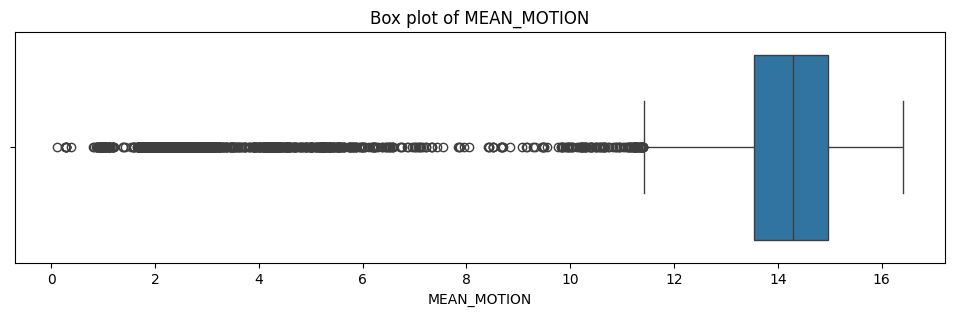

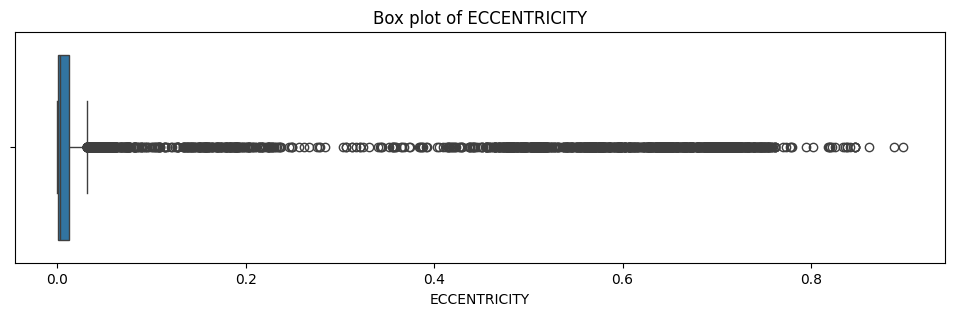

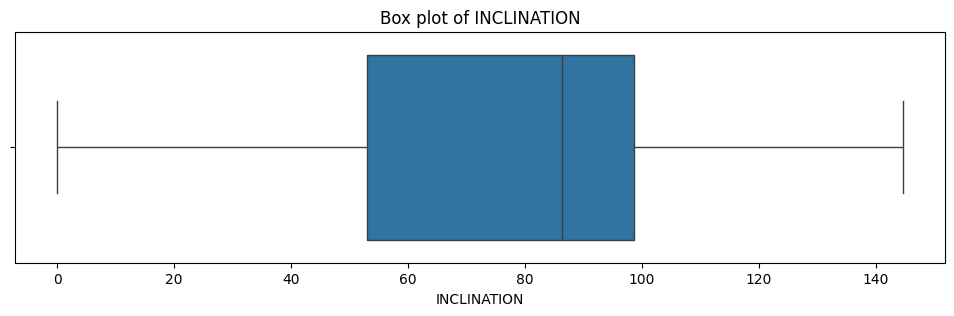

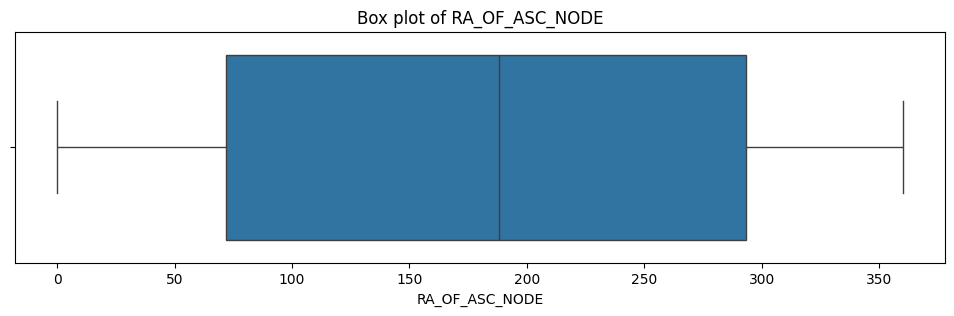

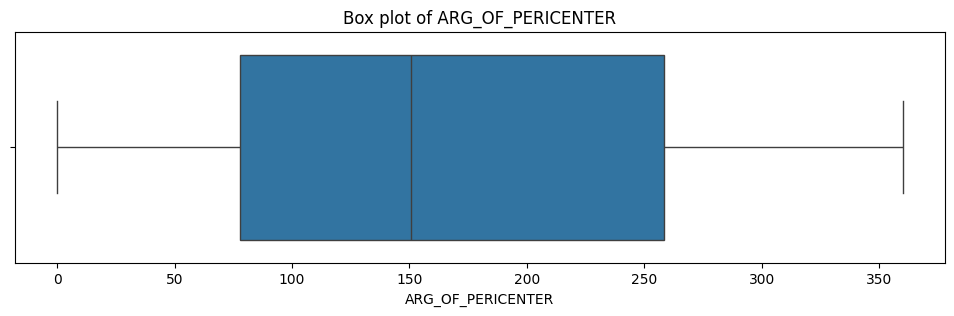

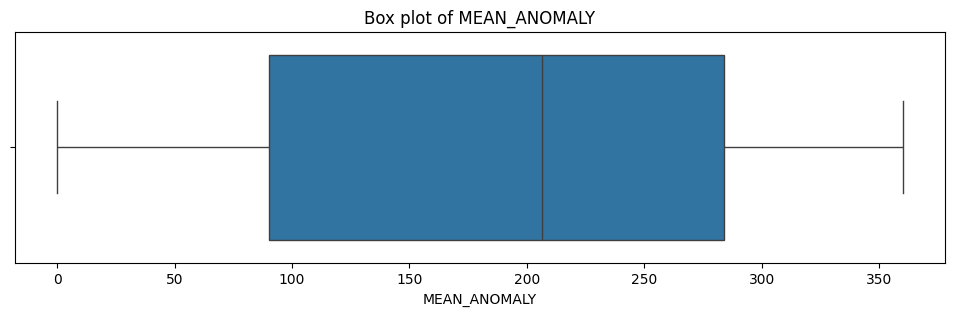

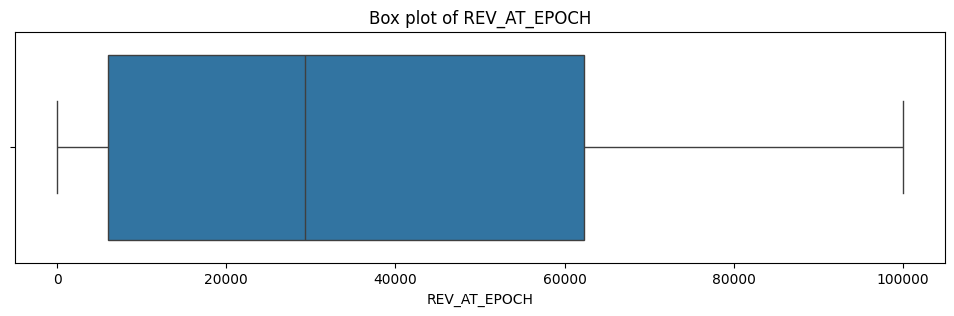

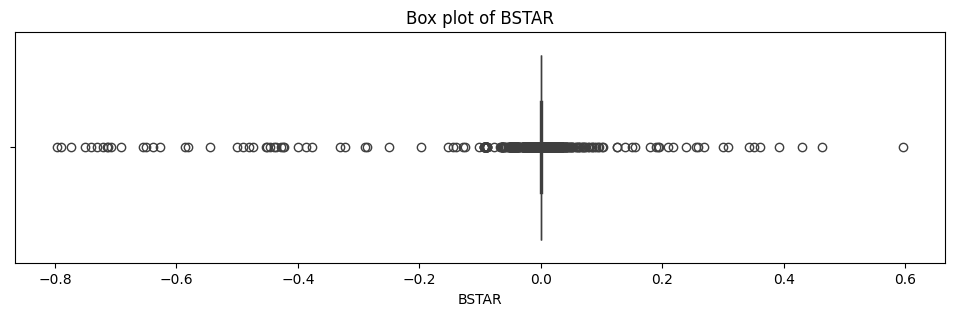

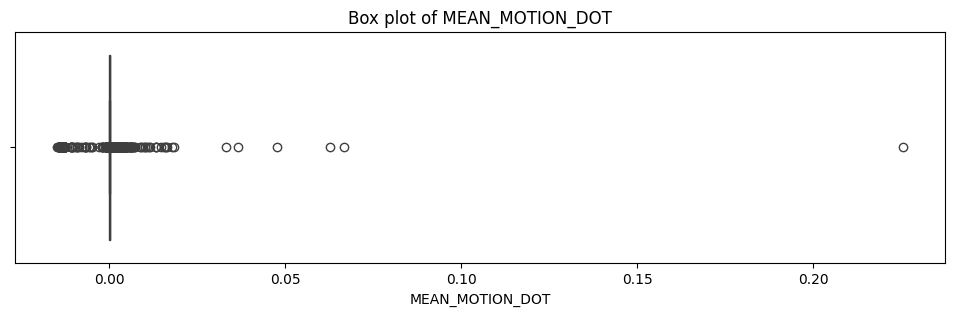

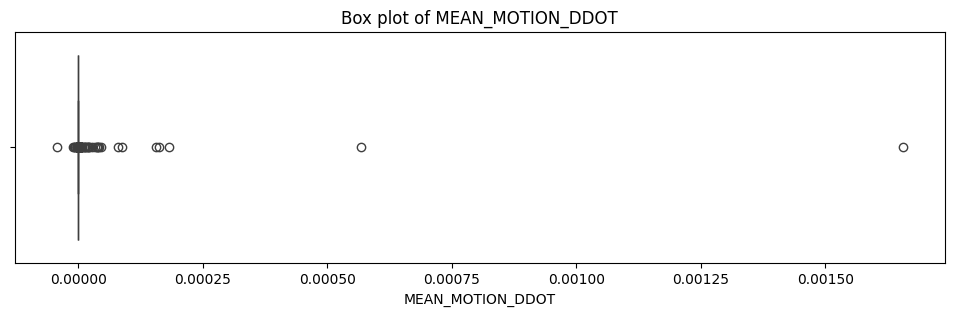

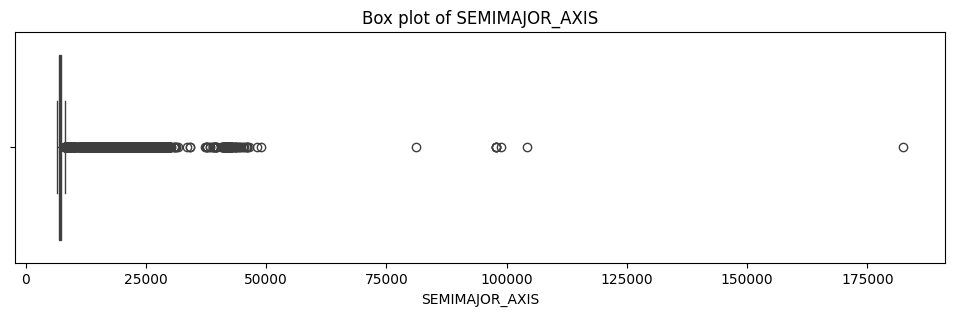

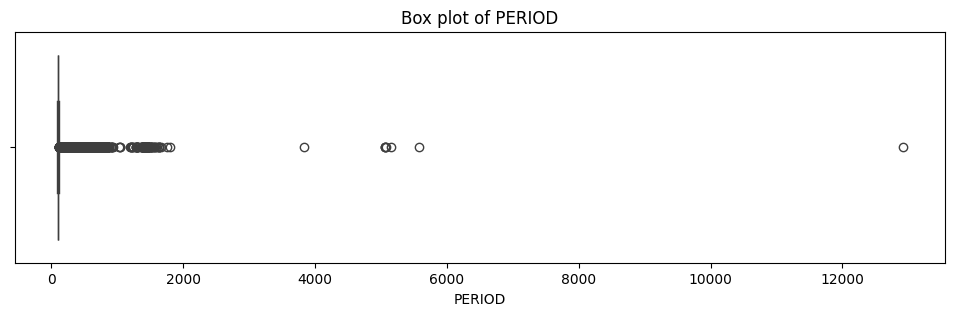

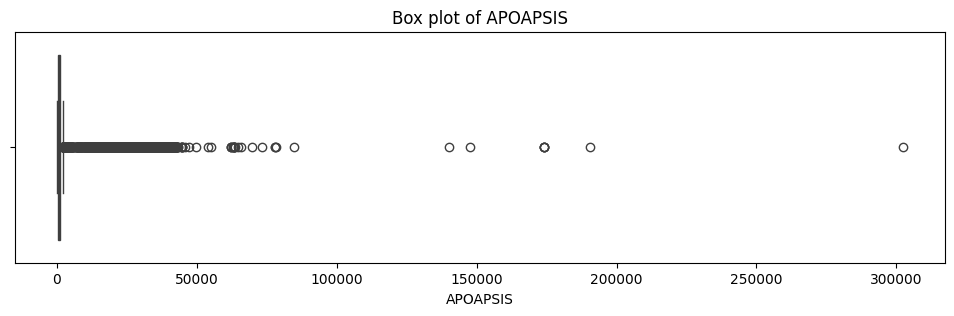

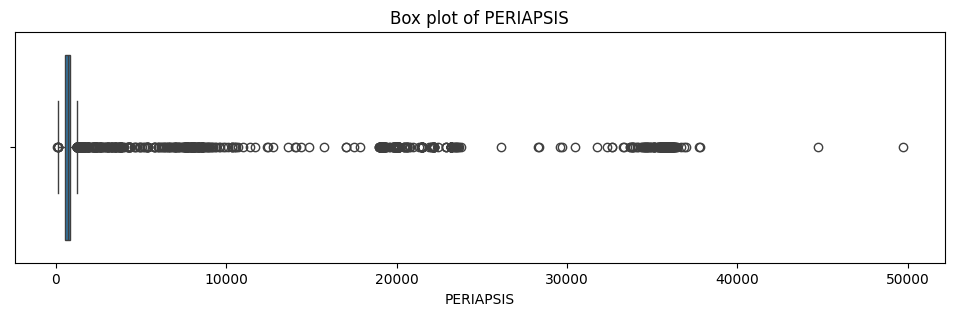

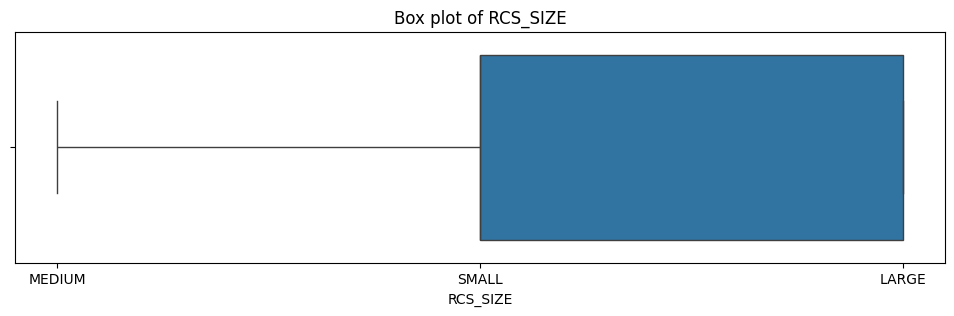

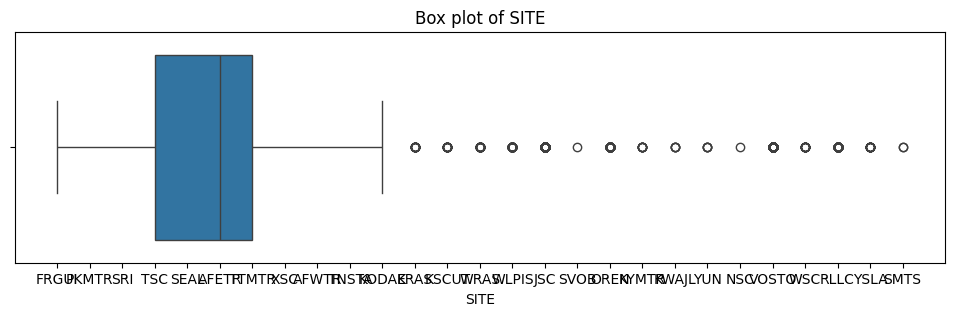

In [33]:
for col in debris_X.columns:
    plt.figure(figsize=(12, 3))
    sns.boxplot(x=debris_X[col])
    plt.title(f'Box plot of {col}')
    

In [36]:
q1 = debris_X[cont_cols].quantile(0.25)
q3 = debris_X[cont_cols].quantile(0.75)

iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
debris_X = debris_X[~((debris_X[cont_cols] < lower_bound) | (debris_X[cont_cols] > upper_bound)).any(axis=1)]
debris_y = debris_y[debris_X.index]

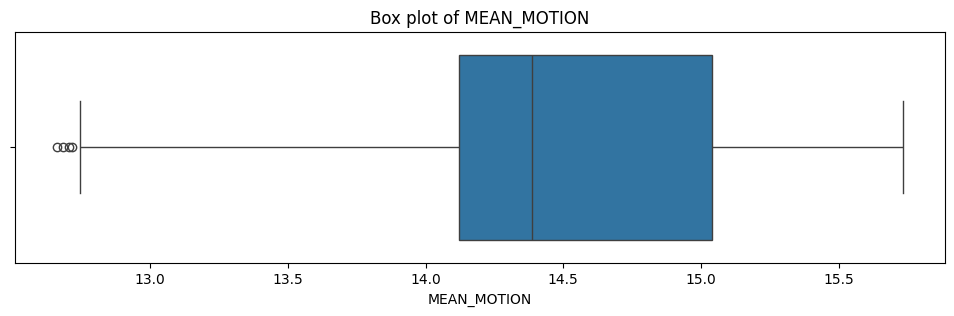

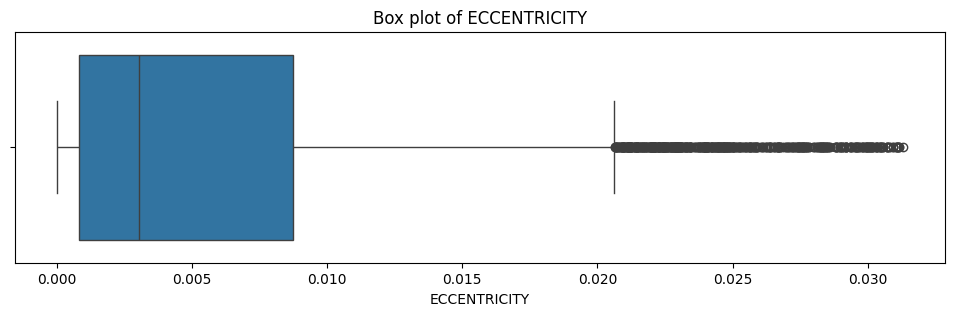

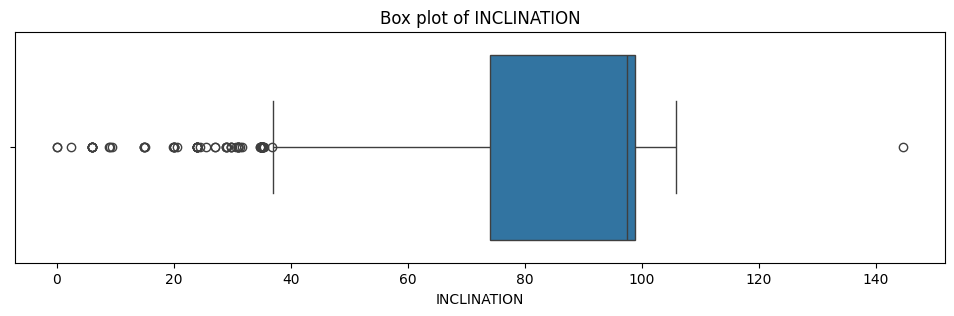

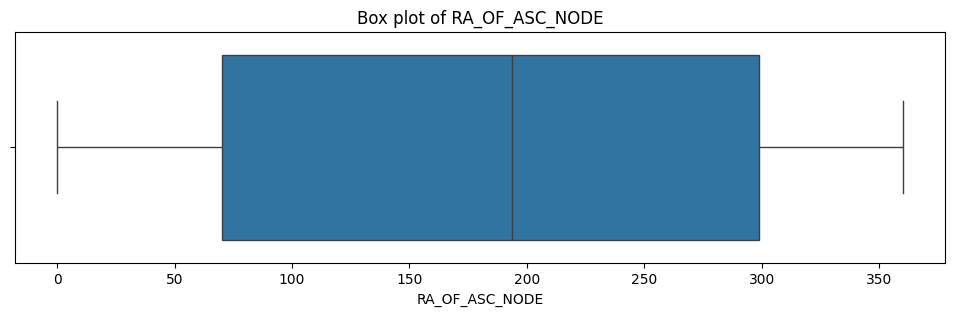

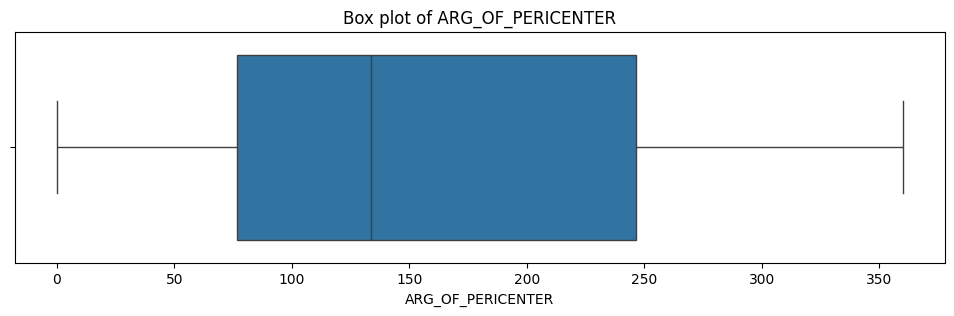

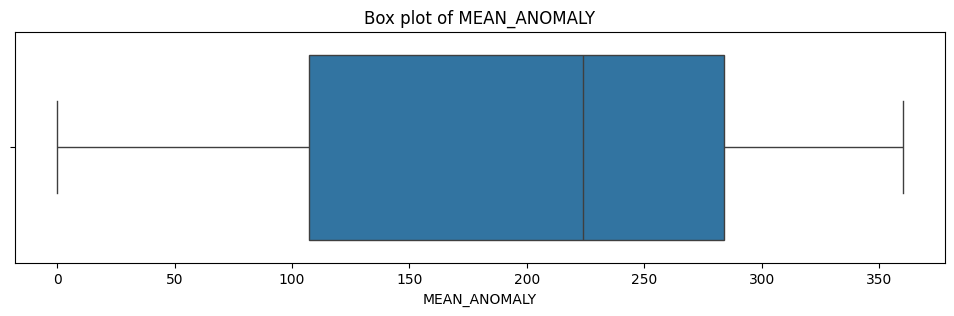

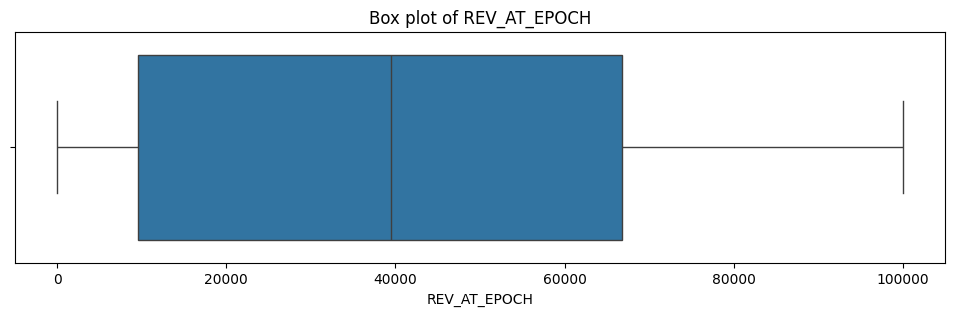

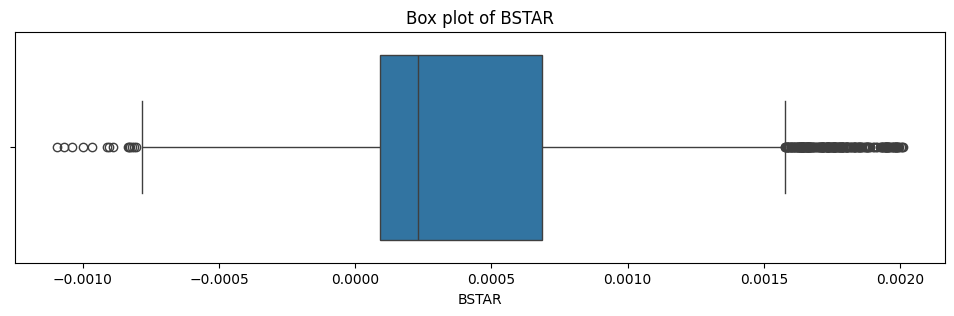

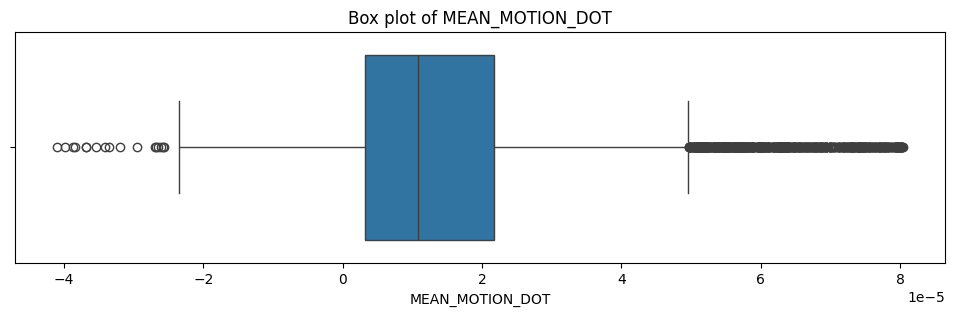

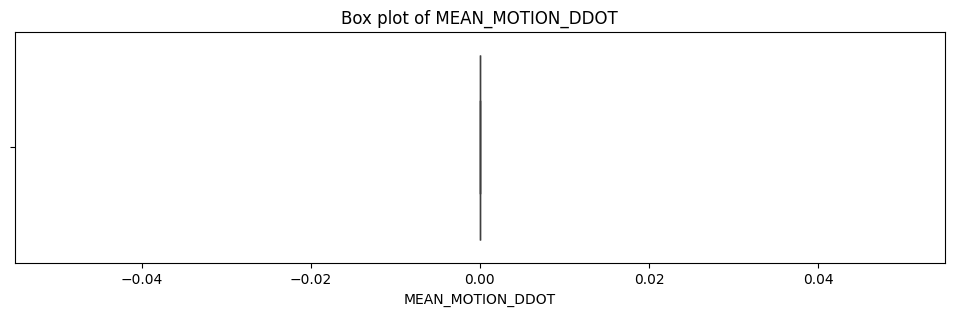

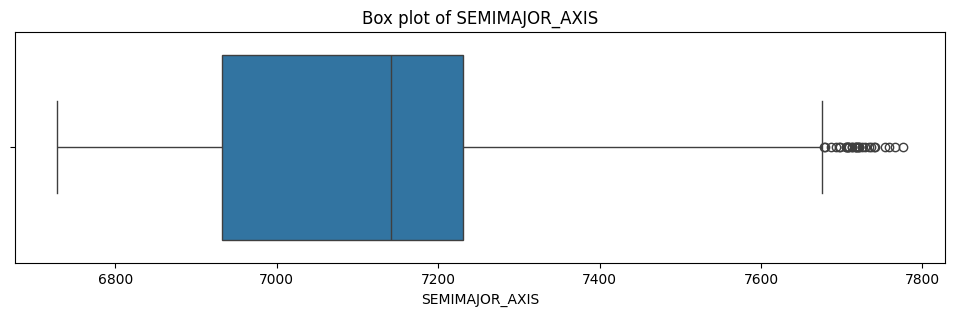

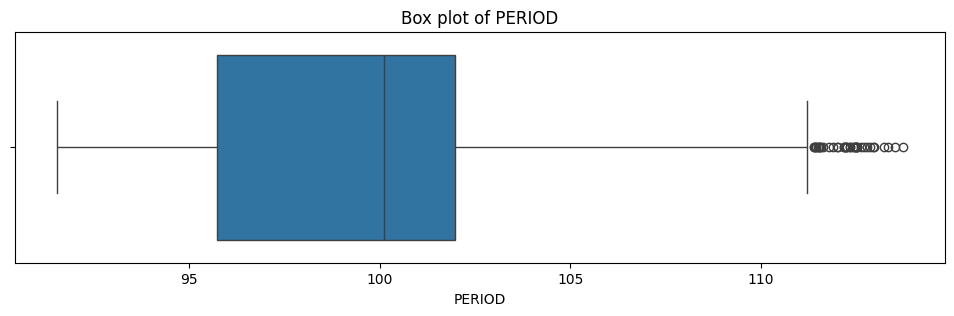

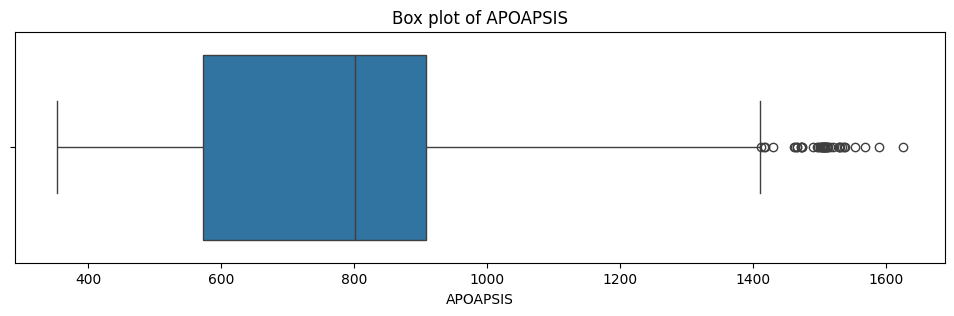

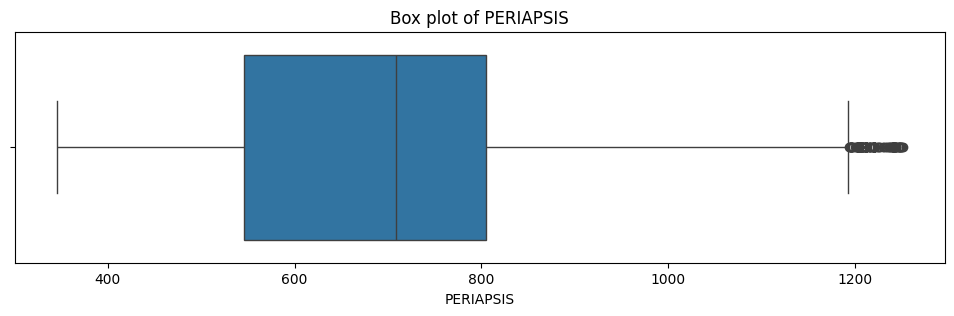

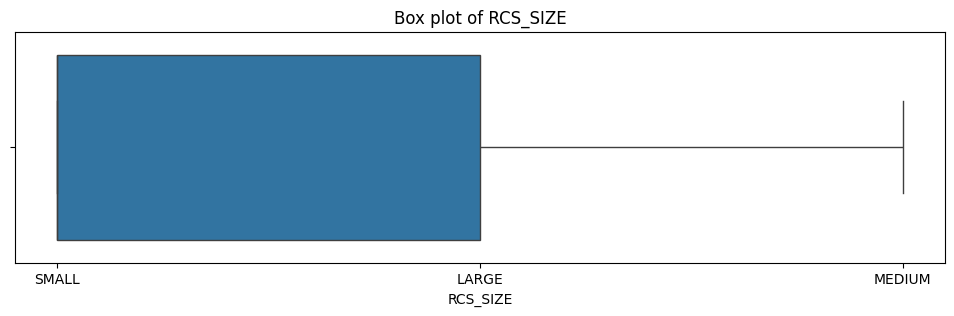

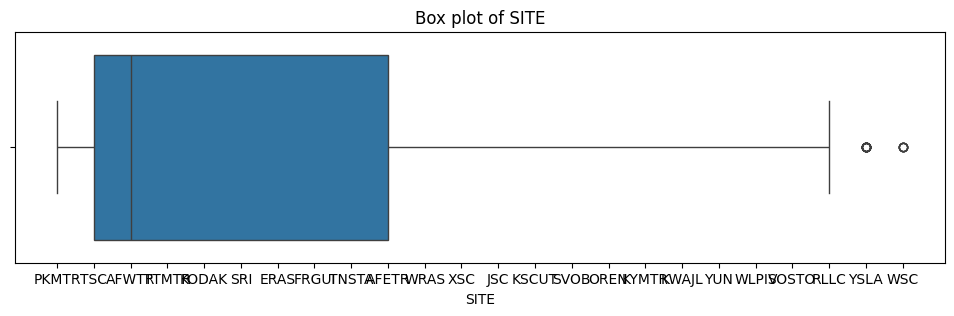

In [37]:
for col in debris_X.columns:
    plt.figure(figsize=(12, 3))
    sns.boxplot(x=debris_X[col])
    plt.title(f'Box plot of {col}')


In [38]:
for debris_type in debris_y.unique():
    count = 0
    for label in debris_y:
        if label == debris_type:
            count += 1
    print(f"Count of {debris_type}: {count}")

Count of DEBRIS: 5589
Count of PAYLOAD: 3022
Count of ROCKET BODY: 178
Count of TBA: 177


From the above result, we can see the the dataset has a high imbalance

In [39]:
ros = RandomOverSampler(random_state=42)

In [40]:
debris_X, debris_y = ros.fit_resample(debris_X, debris_y)

In [41]:
for debris_type in debris_y.unique():
    count = 0
    for label in debris_y:
        if label == debris_type:
            count += 1
    print(f"Count of {debris_type}: {count}")

Count of DEBRIS: 5589
Count of PAYLOAD: 5589
Count of ROCKET BODY: 5589
Count of TBA: 5589


In [43]:
debris_X

,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,RCS_SIZE,SITE
0,13.754973,0.003072,82.9193,299.1120,158.9093,201.3337,50124,0.000066,7.900000e-07,0.0,7358.038,104.689,1002.507,957.299,SMALL,PKMTR
1,14.775907,0.006062,98.4781,8.7205,37.3771,323.1632,10204,0.000316,2.265000e-05,0.0,7015.076,97.456,679.465,594.417,SMALL,TSC
2,14.724482,0.006226,98.4232,122.0724,345.1605,27.6061,9622,0.000408,2.610000e-05,0.0,7031.400,97.796,697.039,609.491,SMALL,TSC
3,14.384765,0.008523,98.7597,287.9689,54.5300,306.3803,8096,0.000083,2.180000e-06,0.0,7141.674,100.106,824.406,702.671,SMALL,TSC
4,13.496296,0.006741,100.3344,151.9642,291.8206,198.6383,1539,0.001505,9.170000e-06,0.0,7451.758,106.696,1123.854,1023.393,SMALL,AFWTR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22351,15.141591,0.001793,97.4735,4.3133,10.8998,65.1626,4275,0.000058,9.960000e-06,0.0,6901.670,95.102,535.906,511.163,MEDIUM,AFETR
22352,15.224380,0.004005,60.6847,139.7357,116.7595,243.7598,4370,0.000307,7.033000e-05,0.0,6876.626,94.585,526.035,470.948,SMALL,WRAS
22353,15.123496,0.000867,97.5660,27.1105,353.6258,69.9020,15998,0.000233,3.983000e-05,0.0,6907.174,95.216,535.027,523.051,SMALL,JSC
22354,14.958668,0.001342,97.6394,11.6385,313.3659,46.6460,15849,-0.000002,-8.000000e-07,0.0,6957.821,96.265,589.025,570.346,SMALL,AFWTR


In [44]:
scaler = StandardScaler()

In [45]:
debris_X[cont_cols] = scaler.fit_transform(debris_X[cont_cols])

In [46]:
debris_X

,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,RCS_SIZE,SITE
0,-1.553392,-0.318769,-0.055421,299.1120,-0.054961,0.045822,0.731474,-0.498666,-0.843838,0.0,1.535512,1.530930,1.274804,1.790870,SMALL,PKMTR
1,0.197290,0.133948,0.683565,8.7205,-1.236749,1.208465,-0.692626,0.251470,0.303888,0.0,-0.220931,-0.225424,-0.168874,-0.276214,SMALL,TSC
2,0.109108,0.158736,0.680958,122.0724,1.756158,-1.612094,-0.713388,0.528708,0.485025,0.0,-0.137330,-0.142864,-0.090336,-0.190348,SMALL,TSC
3,-0.473435,0.506609,0.696940,287.9689,-1.069953,1.048302,-0.767827,-0.446170,-0.770859,0.0,0.427427,0.418062,0.478869,0.340433,SMALL,TSC
4,-1.996967,0.236763,0.771733,151.9642,1.237477,0.020100,-1.001740,3.822502,-0.403859,0.0,2.015489,2.018280,1.817105,2.167361,SMALL,AFWTR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22351,0.824360,-0.512497,0.635850,4.3133,-1.494216,-1.253685,-0.904136,-0.522311,-0.362381,0.0,-0.801728,-0.797035,-0.810441,-0.750453,MEDIUM,AFETR
22352,0.966325,-0.177433,-1.111484,139.7357,-0.464829,0.450703,-0.900747,0.224980,2.807256,0.0,-0.929988,-0.922575,-0.854554,-0.979530,SMALL,WRAS
22353,0.793330,-0.652667,0.640244,27.1105,1.838476,-1.208456,-0.485932,0.004175,1.205899,0.0,-0.773540,-0.769353,-0.814369,-0.682736,SMALL,JSC
22354,0.510685,-0.580682,0.643730,11.6385,1.446985,-1.430392,-0.491247,-0.702812,-0.927319,0.0,-0.514157,-0.514629,-0.573051,-0.413329,SMALL,AFWTR


In [47]:
le = LabelEncoder()
debris_X[categ_cols] = debris_X[categ_cols].apply(le.fit_transform)
debris_y = le.fit_transform(debris_y)

In [48]:
debris_X

,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,RCS_SIZE,SITE
0,-1.553392,-0.318769,-0.055421,299.1120,-0.054961,0.045822,0.731474,-0.498666,-0.843838,0.0,1.535512,1.530930,1.274804,1.790870,2,10
1,0.197290,0.133948,0.683565,8.7205,-1.236749,1.208465,-0.692626,0.251470,0.303888,0.0,-0.220931,-0.225424,-0.168874,-0.276214,2,15
2,0.109108,0.158736,0.680958,122.0724,1.756158,-1.612094,-0.713388,0.528708,0.485025,0.0,-0.137330,-0.142864,-0.090336,-0.190348,2,15
3,-0.473435,0.506609,0.696940,287.9689,-1.069953,1.048302,-0.767827,-0.446170,-0.770859,0.0,0.427427,0.418062,0.478869,0.340433,2,15
4,-1.996967,0.236763,0.771733,151.9642,1.237477,0.020100,-1.001740,3.822502,-0.403859,0.0,2.015489,2.018280,1.817105,2.167361,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22351,0.824360,-0.512497,0.635850,4.3133,-1.494216,-1.253685,-0.904136,-0.522311,-0.362381,0.0,-0.801728,-0.797035,-0.810441,-0.750453,1,0
22352,0.966325,-0.177433,-1.111484,139.7357,-0.464829,0.450703,-0.900747,0.224980,2.807256,0.0,-0.929988,-0.922575,-0.854554,-0.979530,2,19
22353,0.793330,-0.652667,0.640244,27.1105,1.838476,-1.208456,-0.485932,0.004175,1.205899,0.0,-0.773540,-0.769353,-0.814369,-0.682736,2,4
22354,0.510685,-0.580682,0.643730,11.6385,1.446985,-1.430392,-0.491247,-0.702812,-0.927319,0.0,-0.514157,-0.514629,-0.573051,-0.413329,2,1


In [49]:
debris_y

array([0, 0, 0, ..., 3, 3, 3], shape=(22356,))

In [50]:
train_df, test_df = train_test_split(debris_X, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(debris_y, test_size=0.2, random_state=42)


X_train_cat = torch.tensor(train_df[categ_cols].values, dtype=torch.long)
X_train_cont = torch.tensor(train_df[cont_cols].values, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test_cat = torch.tensor(test_df[categ_cols].values, dtype=torch.long)
X_test_cont = torch.tensor(test_df[cont_cols].values, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.long)

In [51]:
for col in categ_cols:
    print(f"{col}: {debris_X[col].nunique()}")

RCS_SIZE: 3
SITE: 24


In [52]:
model = TabTransformer(
    categories=(3, 27),  # number of unique values per categorical column
    num_continuous=len(cont_cols),
    dim=32,
    depth=4,
    heads=6,
    dim_head=16,
    attn_dropout=0.2,
    ff_dropout=0.2,
    mlp_hidden_mults=(4, 2),
    mlp_act=nn.LeakyReLU(),
    dim_out=len(set(debris_y)),
)


In [53]:
model

TabTransformer(
  (category_embed): Embedding(32, 28)
  (norm): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-3): 4 x ModuleList(
        (0): HyperConnections(
          (branch): PreNorm(
            (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (to_qkv): Linear(in_features=32, out_features=288, bias=False)
              (to_out): Linear(in_features=96, out_features=32, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
          )
          (act): Tanh()
          (split_fracs): Rearrange('b ... (f d) -> b ... f d', f=1)
          (merge_fracs): Rearrange('b ... f d -> b ... (f d)')
          (norm): RMSNorm()
          (dropout): Dropout(p=0.0, inplace=False)
          (residual_transform): Identity()
        )
        (1): HyperConnections(
          (branch): PreNorm(
            (norm): LayerNorm((32,), eps=1e-05, elementw

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [55]:
epochs = 1000
patience = 5
best_val_loss = float('inf')
best_model_wts = None
counter = 0

loss_list = []
acc_list = []

for epoch in range(epochs):
    model.train()

    optimizer.zero_grad()
    outputs = model(X_train_cat, X_train_cont)
    loss = criterion(outputs, y_train)
    loss_list.append(loss.item())
    loss.backward()
    optimizer.step()

    model.eval()

    with torch.no_grad():
        pred_vals = model(X_test_cat, X_test_cont)
        val_loss = criterion(pred_vals, y_test)
        val_acc = (pred_vals.argmax(dim=1) == y_test).float().mean().item()
        acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0

    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

Epoch 1/1000, Loss: 1.3429, Val Loss: 0.9783, Val Acc: 0.7160
Epoch 2/1000, Loss: 0.9892, Val Loss: 0.7807, Val Acc: 0.7310
Epoch 3/1000, Loss: 0.7869, Val Loss: 0.6667, Val Acc: 0.7556
Epoch 4/1000, Loss: 0.6694, Val Loss: 0.6163, Val Acc: 0.7639
Epoch 5/1000, Loss: 0.6158, Val Loss: 0.6020, Val Acc: 0.7726
Epoch 6/1000, Loss: 0.6001, Val Loss: 0.5878, Val Acc: 0.7824
Epoch 7/1000, Loss: 0.5885, Val Loss: 0.5734, Val Acc: 0.7858
Epoch 8/1000, Loss: 0.5763, Val Loss: 0.5594, Val Acc: 0.8119
Epoch 9/1000, Loss: 0.5613, Val Loss: 0.5445, Val Acc: 0.8200
Epoch 10/1000, Loss: 0.5468, Val Loss: 0.5360, Val Acc: 0.8178
Epoch 11/1000, Loss: 0.5414, Val Loss: 0.5244, Val Acc: 0.8220
Epoch 12/1000, Loss: 0.5336, Val Loss: 0.5074, Val Acc: 0.8251
Epoch 13/1000, Loss: 0.5174, Val Loss: 0.4938, Val Acc: 0.8280
Epoch 14/1000, Loss: 0.5054, Val Loss: 0.4821, Val Acc: 0.8285
Epoch 15/1000, Loss: 0.4942, Val Loss: 0.4718, Val Acc: 0.8336
Epoch 16/1000, Loss: 0.4857, Val Loss: 0.4635, Val Acc: 0.8365
E

The model has been trained for 173 epochs before early stopping

Testing the model

In [56]:
model.load_state_dict(best_model_wts)
# Testing the model

model.eval()
y_pred = model(X_test_cat, X_test_cont).argmax(dim=1)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

      DEBRIS       0.97      0.98      0.98      1110
     PAYLOAD       0.96      0.83      0.89      1114
 ROCKET BODY       0.93      0.99      0.96      1120
         TBA       0.90      0.97      0.93      1128

    accuracy                           0.94      4472
   macro avg       0.94      0.94      0.94      4472
weighted avg       0.94      0.94      0.94      4472



In [ ]:
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")

Accuracy Score: 0.9401


In [57]:
conf_mat = confusion_matrix(y_test, y_pred)

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

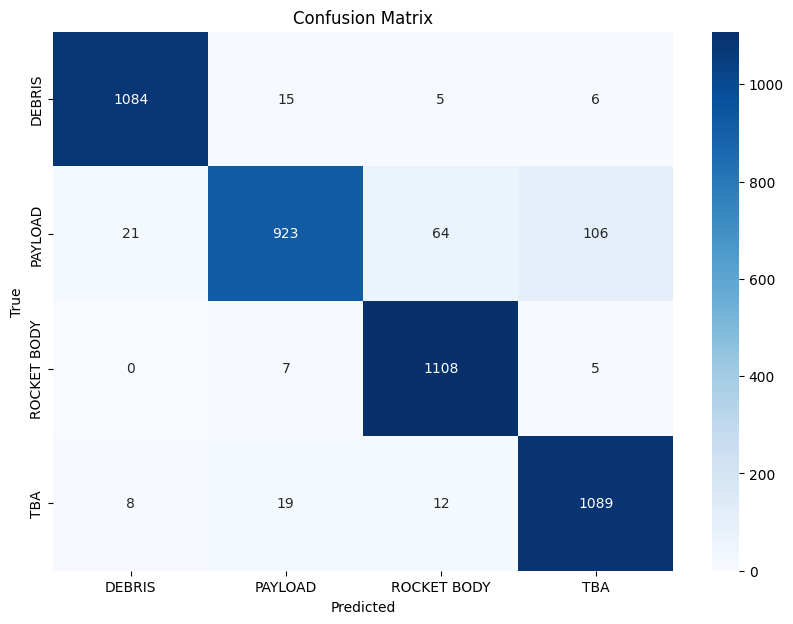

In [59]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Text(0.5, 1.0, 'Training Loss and Validation Accuracy over Epochs')

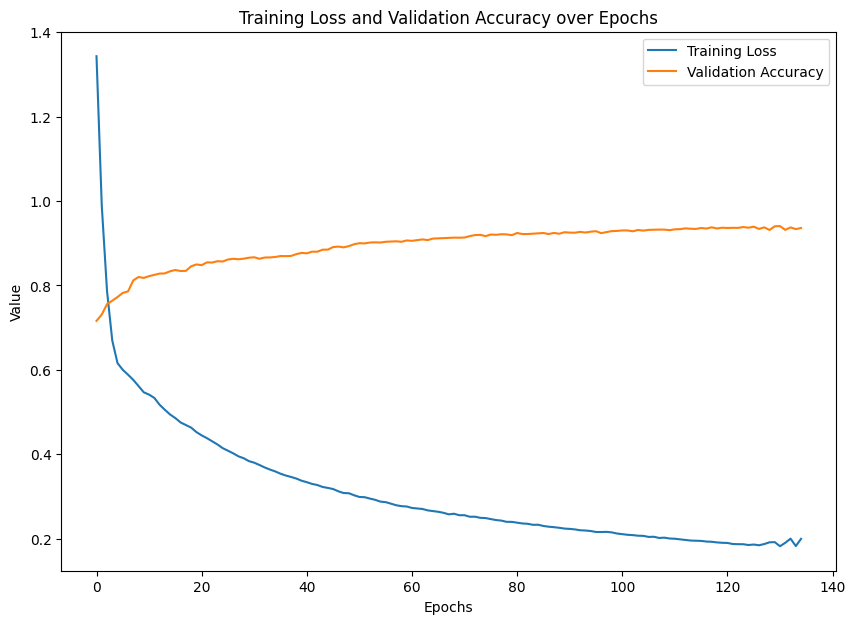

In [60]:
plt.figure(figsize=(10, 7))
plt.plot(loss_list, label='Training Loss')
plt.plot(acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.title('Training Loss and Validation Accuracy over Epochs')